# Text classification

In [5]:
import fasttext
import ktrain
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from datasets import load_dataset
pd.options.display.max_colwidth = 150

1. Get acquainted with the data of the Polish Cyberbullying detection dataset. Pay special attention to the distribution of the positive and negative examples in the first task as well as distribution of the classes in the second task.

In [6]:
cyberbulling_1 = load_dataset('poleval2019_cyberbullying','task01')


task1_train = pd.DataFrame(cyberbulling_1['train'])
task1_test = pd.DataFrame(cyberbulling_1['test'])

cyberbulling_2 = load_dataset('poleval2019_cyberbullying','task02')


task2_train = pd.DataFrame(cyberbulling_2['train'])
task2_test = pd.DataFrame(cyberbulling_2['test'])

Generating train split:   0%|          | 0/10041 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset poleval2019_cyberbullying downloaded and prepared to /root/.cache/huggingface/datasets/poleval2019_cyberbullying/task01/1.0.0/ce6060c56dae43c469bab309a7573b86299b0bcc2484e85cfe0ae70b5f770450. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/10041 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset poleval2019_cyberbullying downloaded and prepared to /root/.cache/huggingface/datasets/poleval2019_cyberbullying/task02/1.0.0/ce6060c56dae43c469bab309a7573b86299b0bcc2484e85cfe0ae70b5f770450. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [15]:
task1_train

,text,label
0,"Dla mnie faworytem do tytułu będzie Cracovia. Zobaczymy, czy typ się sprawdzi.",0
1,@anonymized_account @anonymized_account Brawo ty Daria kibic ma być na dobre i złe,0
2,"@anonymized_account @anonymized_account Super, polski premier składa kwiaty na grobach kolaborantów. Ale doczekaliśmy czasów.",0
3,@anonymized_account @anonymized_account Musi. Innej drogi nie mamy.,0
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",0
...,...,...
10036,@anonymized_account Ty zagrasz? Nie wiedziałem 😉,0
10037,"@anonymized_account @anonymized_account A VAR nie miał poprawić jakości sędziowania, tylko efekt końcowy - mniej wypaczonych wyników, mniej skandali.",0
10038,"@anonymized_account @anonymized_account Szanowany, bo kolega ładnie go pożegnał ?",0
10039,@anonymized_account @anonymized_account @anonymized_account A kto inny ma się bić? Każdy zwyciezca ligi wojewódzkiej gra w barazach.,0


### Task 1

In [16]:
task1_train['label'].value_counts()

0    9190
1     851
Name: label, dtype: int64

In [17]:
task1_test['label'].value_counts()

0    866
1    134
Name: label, dtype: int64

### Task 2

In [18]:
task2_train['label'].value_counts()

0    9190
2     598
1     253
Name: label, dtype: int64

2. Train the following classifiers on the training sets (for the task 1 and the task 2):


## Bayesian classifier with TF * IDF weighting


In [8]:
def fit_tfidf_classifier(train, test):
    vectorizer = TfidfVectorizer()
    vectorizer.fit((train['text'] + test['text']).values.astype('U'))

    X_train = vectorizer.transform(train['text']).toarray()
    X_train = pd.DataFrame(X_train, columns=vectorizer.get_feature_names())

    Y_train = train['label']

    classifier = MultinomialNB()
    classifier.fit(X_train, Y_train)

    return vectorizer, classifier

### Task 1

In [20]:
task_1_tfidf_vectorizer, task_1_tfidf_classifier = fit_tfidf_classifier(
    task1_train,
    task1_test
)

### Task 2

In [21]:
task_2_tfidf_vectorizer, task_2_tfidf_classifier = fit_tfidf_classifier(
    task2_train,
    task2_test
)

## Fasttext text classifier


In [7]:
def text_to_fast_text_input(train_data, output_path):
    with open(output_path, 'w+') as file:
        for _, row in train_data.iterrows():
            label = row['label']
            data = row['text'].replace('\n', ' ')
            file.write(f'__label__{label} {data}')
            file.write('\n')

### Task 1

In [23]:
text_to_fast_text_input(task1_train, f'fast_text_task_1_train.txt')

In [24]:
! head -n 5 fast_text_task_1_train.txt

__label__0 Dla mnie faworytem do tytułu będzie Cracovia. Zobaczymy, czy typ się sprawdzi.
__label__0 @anonymized_account @anonymized_account Brawo ty Daria kibic ma być na dobre i złe
__label__0 @anonymized_account @anonymized_account Super, polski premier składa kwiaty na grobach kolaborantów. Ale doczekaliśmy czasów.
__label__0 @anonymized_account @anonymized_account Musi. Innej drogi nie mamy.
__label__0 Odrzut natychmiastowy, kwaśna mina, mam problem


### Task 2

In [25]:
text_to_fast_text_input(task2_train, f'fast_text_task_2_train.txt')

In [26]:
! head -n 5 fast_text_task_2_train.txt

__label__0 Dla mnie faworytem do tytułu będzie Cracovia. Zobaczymy, czy typ się sprawdzi.
__label__0 @anonymized_account @anonymized_account Brawo ty Daria kibic ma być na dobre i złe
__label__0 @anonymized_account @anonymized_account Super, polski premier składa kwiaty na grobach kolaborantów. Ale doczekaliśmy czasów.
__label__0 @anonymized_account @anonymized_account Musi. Innej drogi nie mamy.
__label__0 Odrzut natychmiastowy, kwaśna mina, mam problem


In [27]:
task_1_fast_text_classifier = fasttext.train_supervised(input=f'fast_text_task_1_train.txt')

In [28]:
task_2_fast_text_classifier = fasttext.train_supervised(input=f'fast_text_task_2_train.txt')

## Transformer classifier (take into account that a number of experiments should be performed for this model).

In [29]:
def fit_transformer_classifier(train, epochs, model_name='allegro/herbert-base-cased'):
    X_train, X_val, y_train, y_val = train_test_split(
        train['text'].values,
        train['label'].values,
        random_state=1234
    )

    transformer = ktrain.text.Transformer(
        model_name,
        maxlen=500,
        class_names=list(set(train['label']))
    )

    preprocessed_train = transformer.preprocess_train(X_train, y_train)
    preprocessed_val = transformer.preprocess_test(X_val, y_val)

    classifier = transformer.get_classifier()
    learner = ktrain.get_learner(
        classifier,
        train_data=preprocessed_train,
        val_data=preprocessed_val,
        batch_size=6
    )
    learner.fit_onecycle(5e-5, epochs)

    return transformer, classifier, learner

### Task 1


In [30]:
task_1_transformer = fit_transformer_classifier(task1_train, 5)
task_1_transformer, task_1_transformer_classifier, task_1_transformer_learner = task_1_transformer

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

preprocessing train...
language: pl
train sequence lengths:
	mean : 12
	95percentile : 21
	99percentile : 24


Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/886k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/129 [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: pl
test sequence lengths:
	mean : 12
	95percentile : 21
	99percentile : 23


Downloading:   0%|          | 0.00/475M [00:00<?, ?B/s]



begin training using onecycle policy with max lr of 5e-05...
Epoch 1/5
1255/1255 [==============================] - 942s 732ms/step - loss: 0.2615 - accuracy: 0.9127 - val_loss: 0.1950 - val_accuracy: 0.9255
Epoch 2/5
1255/1255 [==============================] - 912s 726ms/step - loss: 0.2147 - accuracy: 0.9203 - val_loss: 0.1859 - val_accuracy: 0.9307
Epoch 3/5
1255/1255 [==============================] - 912s 726ms/step - loss: 0.2537 - accuracy: 0.9169 - val_loss: 0.2836 - val_accuracy: 0.9188
Epoch 4/5
1255/1255 [==============================] - 911s 725ms/step - loss: 0.2965 - accuracy: 0.9141 - val_loss: 0.2822 - val_accuracy: 0.9188
Epoch 5/5
1255/1255 [==============================] - 911s 725ms/step - loss: 0.2945 - accuracy: 0.9141 - val_loss: 0.2823 - val_accuracy: 0.9188


### Task 2


In [31]:
task_2_transformer = fit_transformer_classifier(task2_train, 5)
task_2_transformer, task_2_transformer_classifier, task_2_transformer_learner = task_2_transformer

preprocessing train...
language: pl
train sequence lengths:
	mean : 12
	95percentile : 21
	99percentile : 24


Is Multi-Label? False
preprocessing test...
language: pl
test sequence lengths:
	mean : 12
	95percentile : 21
	99percentile : 23




begin training using onecycle policy with max lr of 5e-05...
Epoch 1/5
1255/1255 [==============================] - 930s 728ms/step - loss: 0.3273 - accuracy: 0.9134 - val_loss: 0.3340 - val_accuracy: 0.9188
Epoch 2/5
1255/1255 [==============================] - 912s 726ms/step - loss: 0.3498 - accuracy: 0.9141 - val_loss: 0.3368 - val_accuracy: 0.9188
Epoch 3/5
1255/1255 [==============================] - 912s 726ms/step - loss: 0.3482 - accuracy: 0.9141 - val_loss: 0.3694 - val_accuracy: 0.9188
Epoch 4/5
1255/1255 [==============================] - 912s 725ms/step - loss: 0.3413 - accuracy: 0.9142 - val_loss: 0.3377 - val_accuracy: 0.9188
Epoch 5/5
1255/1255 [==============================] - 912s 726ms/step - loss: 0.3085 - accuracy: 0.9139 - val_loss: 0.2450 - val_accuracy: 0.9188


3. Compare the results of classification on the test set. Select the appropriate measures (from accuracy, F1, macro/micro F1, MCC) to compare the results.

In [20]:
def print_metrics(y_true, y_pred):
    print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
    print(f'F1: {f1_score(y_true, y_pred, average="weighted")}')
    print(f'Macro F1: {f1_score(y_true, y_pred, average="macro")}')
    print(f'Micro F1: {f1_score(y_true, y_pred, average="micro")}')
    print(f'MCC: {matthews_corrcoef(y_true, y_pred)}')

In [21]:
def plot_confusion_matrix(y_true, y_pred, labels):
    matrix = confusion_matrix(y_true, y_pred, labels=labels)
    ax = plt.subplot()
    sns.heatmap(matrix, annot=True, ax=ax, fmt='d', cmap='viridis')

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')

## Bayesian classifier with TF * IDF weighting


### Task 1

In [34]:
task_1_test_X = pd.DataFrame(
    task_1_tfidf_vectorizer.transform(task1_test['text']).toarray(),
    columns=task_1_tfidf_vectorizer.get_feature_names()
)

task1_test['tfidf_prediction'] = task_1_tfidf_classifier.predict(task_1_test_X)

print_metrics(task1_test['label'], task1_test['tfidf_prediction'])

Accuracy: 0.864
F1: 0.8116527315984692
Macro F1: 0.4975691211892834
Micro F1: 0.864
MCC: 0.09144825085554541


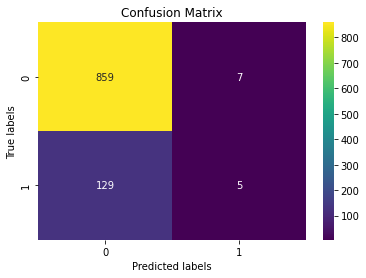

In [35]:
plot_confusion_matrix(task1_test['label'], task1_test['tfidf_prediction'], labels=[0, 1])

In [36]:
task1_test

,text,label,tfidf_prediction
0,"@anonymized_account Spoko, jak im Duda z Morawieckim zamówią po pięć piw to wszystko będzie ok.",0,0
1,"@anonymized_account @anonymized_account Ale on tu nie miał szans jej zagrania, a ta 'proba' to czysta prowizorka.",0,0
2,"@anonymized_account No czy Prezes nie miał racji, mówiąc,ze to są zdradzieckie mordy? No czy nie miał racji?😁😁",0,0
3,@anonymized_account @anonymized_account Przecież to nawet nie jest przewrotka 😂,0,0
4,@anonymized_account @anonymized_account Owszem podatki tak. Ale nie w takich okolicznościach. Czemu Małysza odpalili z teamu Orlen?,0,0
...,...,...,...
995,"@anonymized_account Olej jak kto sie ubiera, patrz na statystyki kolego z tt",0,0
996,@anonymized_account to oczywiste byłyście dziś zajebiste ! No może oprócz Ciebie haha :) #joke,0,0
997,@anonymized_account Duda może się przyjąć w białym domku. Takim z serduszkiem wyciętym w drzwiach,0,0
998,"@anonymized_account Ty jesteś jebnięty, tła takiego parcha mam jechać przez pół polski",1,0


### Task 2

In [37]:
task_2_test_X = pd.DataFrame(
    task_2_tfidf_vectorizer.transform(task2_test['text']).toarray(),
    columns=task_2_tfidf_vectorizer.get_feature_names()
)

task2_test['tfidf_prediction'] = task_2_tfidf_classifier.predict(task_2_test_X)

print_metrics(task2_test['label'], task2_test['tfidf_prediction'])

Accuracy: 0.864
F1: 0.8046767867836468
Macro F1: 0.3148864576105244
Micro F1: 0.864
MCC: 0.02362935702078401


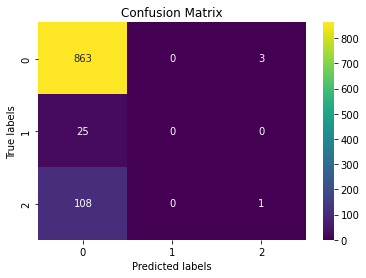

In [38]:
plot_confusion_matrix(task2_test['label'], task2_test['tfidf_prediction'], labels=[0, 1, 2])

In [39]:
task2_test

,text,label,tfidf_prediction
0,"@anonymized_account Spoko, jak im Duda z Morawieckim zamówią po pięć piw to wszystko będzie ok.",0,0
1,"@anonymized_account @anonymized_account Ale on tu nie miał szans jej zagrania, a ta 'proba' to czysta prowizorka.",0,0
2,"@anonymized_account No czy Prezes nie miał racji, mówiąc,ze to są zdradzieckie mordy? No czy nie miał racji?😁😁",0,0
3,@anonymized_account @anonymized_account Przecież to nawet nie jest przewrotka 😂,0,0
4,@anonymized_account @anonymized_account Owszem podatki tak. Ale nie w takich okolicznościach. Czemu Małysza odpalili z teamu Orlen?,0,0
...,...,...,...
995,"@anonymized_account Olej jak kto sie ubiera, patrz na statystyki kolego z tt",0,0
996,@anonymized_account to oczywiste byłyście dziś zajebiste ! No może oprócz Ciebie haha :) #joke,0,0
997,@anonymized_account Duda może się przyjąć w białym domku. Takim z serduszkiem wyciętym w drzwiach,0,0
998,"@anonymized_account Ty jesteś jebnięty, tła takiego parcha mam jechać przez pół polski",2,0


## Fasttext text classifier

In [40]:
task2_test["text"] = task2_test["text"].astype("string")
task1_test["text"] = task1_test["text"].astype("string")
task1_test["fasttext_prediction"] = -1
task2_test["fasttext_prediction"] = -1

In [41]:
task1_test

,text,label,tfidf_prediction,fasttext_prediction
0,"@anonymized_account Spoko, jak im Duda z Morawieckim zamówią po pięć piw to wszystko będzie ok.",0,0,-1
1,"@anonymized_account @anonymized_account Ale on tu nie miał szans jej zagrania, a ta 'proba' to czysta prowizorka.",0,0,-1
2,"@anonymized_account No czy Prezes nie miał racji, mówiąc,ze to są zdradzieckie mordy? No czy nie miał racji?😁😁",0,0,-1
3,@anonymized_account @anonymized_account Przecież to nawet nie jest przewrotka 😂,0,0,-1
4,@anonymized_account @anonymized_account Owszem podatki tak. Ale nie w takich okolicznościach. Czemu Małysza odpalili z teamu Orlen?,0,0,-1
...,...,...,...,...
995,"@anonymized_account Olej jak kto sie ubiera, patrz na statystyki kolego z tt",0,0,-1
996,@anonymized_account to oczywiste byłyście dziś zajebiste ! No może oprócz Ciebie haha :) #joke,0,0,-1
997,@anonymized_account Duda może się przyjąć w białym domku. Takim z serduszkiem wyciętym w drzwiach,0,0,-1
998,"@anonymized_account Ty jesteś jebnięty, tła takiego parcha mam jechać przez pół polski",1,0,-1


In [42]:
for index, row in task1_test.iterrows():
    task1_test.at[index, 'fasttext_prediction'] = int(task_1_fast_text_classifier.predict(row["text"])[0][0][-1])

In [43]:
for index, row in task2_test.iterrows():
    task2_test.at[index, 'fasttext_prediction'] = int(task_2_fast_text_classifier.predict(row["text"])[0][0][-1])

In [44]:
task2_test

,text,label,tfidf_prediction,fasttext_prediction
0,"@anonymized_account Spoko, jak im Duda z Morawieckim zamówią po pięć piw to wszystko będzie ok.",0,0,0
1,"@anonymized_account @anonymized_account Ale on tu nie miał szans jej zagrania, a ta 'proba' to czysta prowizorka.",0,0,0
2,"@anonymized_account No czy Prezes nie miał racji, mówiąc,ze to są zdradzieckie mordy? No czy nie miał racji?😁😁",0,0,0
3,@anonymized_account @anonymized_account Przecież to nawet nie jest przewrotka 😂,0,0,0
4,@anonymized_account @anonymized_account Owszem podatki tak. Ale nie w takich okolicznościach. Czemu Małysza odpalili z teamu Orlen?,0,0,0
...,...,...,...,...
995,"@anonymized_account Olej jak kto sie ubiera, patrz na statystyki kolego z tt",0,0,0
996,@anonymized_account to oczywiste byłyście dziś zajebiste ! No może oprócz Ciebie haha :) #joke,0,0,0
997,@anonymized_account Duda może się przyjąć w białym domku. Takim z serduszkiem wyciętym w drzwiach,0,0,0
998,"@anonymized_account Ty jesteś jebnięty, tła takiego parcha mam jechać przez pół polski",2,0,0


### Task 1

In [45]:
print_metrics(task1_test['label'], task1_test['fasttext_prediction'])

Accuracy: 0.873
F1: 0.8403472194245408
Macro F1: 0.5939365453911798
Micro F1: 0.8729999999999999
MCC: 0.2650301059500807


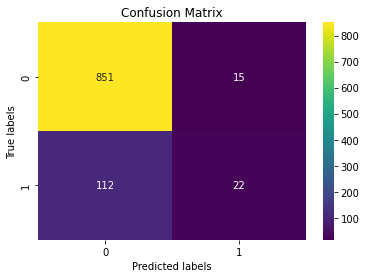

In [46]:
plot_confusion_matrix(task1_test['label'], task1_test['fasttext_prediction'], labels=[0, 1])

### Task 2

In [47]:
print_metrics(task2_test['label'], task2_test['fasttext_prediction'])

Accuracy: 0.868
F1: 0.815413664293688
Macro F1: 0.36843539780455736
Micro F1: 0.868
MCC: 0.16001981125515372


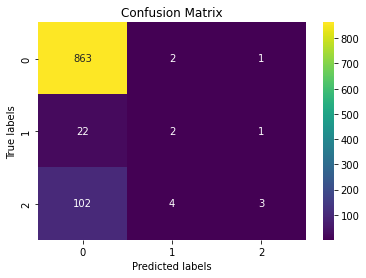

In [48]:
plot_confusion_matrix(task2_test['label'], task2_test['fasttext_prediction'], labels=[0, 1, 2])

## Transformer classifier (take into account that a number of experiments should be performed for this model).

### Task 1

In [49]:
task_1_predictor = ktrain.get_predictor(
    task_1_transformer_learner.model,
    preproc=task_1_transformer
)

task1_test['transformer_prediction'] =  [
  task_1_predictor.predict(text)
  for text
  in task1_test['text']
]

print_metrics(task1_test['label'], task1_test['transformer_prediction'])

1/1 [==============================] - 0s 94ms/step
Accuracy: 0.866
F1: 0.8038113612004287
Macro F1: 0.4640943193997856
Micro F1: 0.866
MCC: 0.0


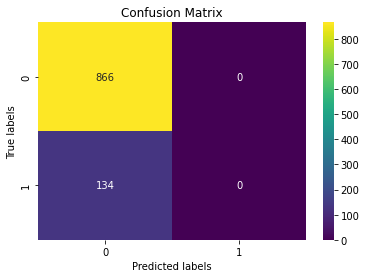

In [50]:
plot_confusion_matrix(task1_test['label'], task1_test['transformer_prediction'], labels=[0, 1])

In [51]:
task1_test

,text,label,tfidf_prediction,fasttext_prediction,transformer_prediction
0,"@anonymized_account Spoko, jak im Duda z Morawieckim zamówią po pięć piw to wszystko będzie ok.",0,0,0,0
1,"@anonymized_account @anonymized_account Ale on tu nie miał szans jej zagrania, a ta 'proba' to czysta prowizorka.",0,0,0,0
2,"@anonymized_account No czy Prezes nie miał racji, mówiąc,ze to są zdradzieckie mordy? No czy nie miał racji?😁😁",0,0,0,0
3,@anonymized_account @anonymized_account Przecież to nawet nie jest przewrotka 😂,0,0,0,0
4,@anonymized_account @anonymized_account Owszem podatki tak. Ale nie w takich okolicznościach. Czemu Małysza odpalili z teamu Orlen?,0,0,0,0
...,...,...,...,...,...
995,"@anonymized_account Olej jak kto sie ubiera, patrz na statystyki kolego z tt",0,0,0,0
996,@anonymized_account to oczywiste byłyście dziś zajebiste ! No może oprócz Ciebie haha :) #joke,0,0,0,0
997,@anonymized_account Duda może się przyjąć w białym domku. Takim z serduszkiem wyciętym w drzwiach,0,0,0,0
998,"@anonymized_account Ty jesteś jebnięty, tła takiego parcha mam jechać przez pół polski",1,0,1,0


### Task 2 

In [52]:
task_2_predictor = ktrain.get_predictor(
    task_2_transformer_learner.model,
    preproc=task_2_transformer
)

task2_test['transformer_prediction'] =  [
  task_2_predictor.predict(text)
  for text
  in task1_test['text']
]

print_metrics(task2_test['label'], task2_test['transformer_prediction'])

1/1 [==============================] - 0s 103ms/step
Accuracy: 0.867
F1: 0.8062241774311479
Macro F1: 0.31562271508652207
Micro F1: 0.867
MCC: 0.08065057569503517


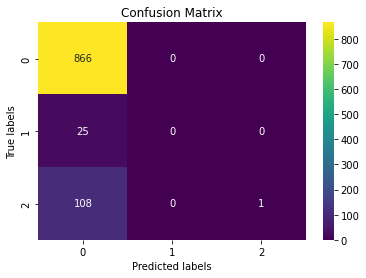

In [53]:
plot_confusion_matrix(task2_test['label'], task2_test['transformer_prediction'], labels=[0, 1, 2])

4. Select 1 TP, 1 TN, 1 FP and 1 FN from your predictions (for the best classifier) and compare the decisions of each classifier on these examples using LIME.

In [54]:
task1_test

,text,label,tfidf_prediction,fasttext_prediction,transformer_prediction
0,"@anonymized_account Spoko, jak im Duda z Morawieckim zamówią po pięć piw to wszystko będzie ok.",0,0,0,0
1,"@anonymized_account @anonymized_account Ale on tu nie miał szans jej zagrania, a ta 'proba' to czysta prowizorka.",0,0,0,0
2,"@anonymized_account No czy Prezes nie miał racji, mówiąc,ze to są zdradzieckie mordy? No czy nie miał racji?😁😁",0,0,0,0
3,@anonymized_account @anonymized_account Przecież to nawet nie jest przewrotka 😂,0,0,0,0
4,@anonymized_account @anonymized_account Owszem podatki tak. Ale nie w takich okolicznościach. Czemu Małysza odpalili z teamu Orlen?,0,0,0,0
...,...,...,...,...,...
995,"@anonymized_account Olej jak kto sie ubiera, patrz na statystyki kolego z tt",0,0,0,0
996,@anonymized_account to oczywiste byłyście dziś zajebiste ! No może oprócz Ciebie haha :) #joke,0,0,0,0
997,@anonymized_account Duda może się przyjąć w białym domku. Takim z serduszkiem wyciętym w drzwiach,0,0,0,0
998,"@anonymized_account Ty jesteś jebnięty, tła takiego parcha mam jechać przez pół polski",1,0,1,0


In [55]:
best_classifier = 'fasttext_prediction'

tp = task1_test[(task1_test['label'] == 1) & (task1_test[best_classifier] == 1)]['text'].iloc[:1].values
fp = task1_test[(task1_test['label'] == 0) & (task1_test[best_classifier] == 1)]['text'].iloc[:1].values
tn = task1_test[(task1_test['label'] == 0) & (task1_test[best_classifier] == 0)]['text'].iloc[:1].values
fn = task1_test[(task1_test['label'] == 1) & (task1_test[best_classifier] == 0)]['text'].iloc[:1].values

In [56]:
print(f'TP: "{tp[0]}"')
print(f'FP: "{fp[0]}"')
print(f'TN: "{tn[0]}"')
print(f'FN: "{fn[0]}"')

TP: "@anonymized_account Dokładnie wie co mówi. A Ty pajacu poczytaj ustawę domsie dowiesz kto decyduje o wysokości zarobków w samorządach."
FP: "@anonymized_account @anonymized_account To Pani Krysia jest Twoją Ojczyzną?"
TN: "@anonymized_account Spoko, jak im Duda z Morawieckim zamówią po pięć piw to wszystko będzie ok."
FN: "@anonymized_account Tej szmaty się nie komentuje"


In [57]:
c = make_pipeline(task_1_tfidf_vectorizer, task_1_tfidf_classifier)
explainer = LimeTextExplainer(class_names=[0, 1])

def explain_prediction(text):
    exp = explainer.explain_instance(
        text, c.predict_proba, num_features=10
    )
    return pd.DataFrame(exp.as_list())

True Positive

In [58]:
explain_prediction(tp[0])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(


,0,1
0,pajacu,0.087960
1,zarobków,0.058219
2,domsie,0.057744
3,ustawę,0.057457
4,kto,-0.054860
5,co,-0.047394
6,mówi,-0.044027
7,Dokładnie,-0.035012
8,samorządach,0.029425
9,poczytaj,-0.021981


False Positive

In [59]:
explain_prediction(fp[0])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(


,0,1
0,Ojczyzną,0.066420
1,Krysia,0.065301
2,anonymized_account,-0.053542
3,jest,-0.048929
4,To,-0.039788
5,Pani,0.017779
6,Twoją,0.009248


True Negative

In [60]:
explain_prediction(tn[0])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(


,0,1
0,ok,-0.035491
1,zamówią,0.027206
2,piw,0.026685
3,będzie,-0.023697
4,Spoko,-0.020090
5,Morawieckim,0.018663
6,to,-0.014606
7,po,-0.014582
8,wszystko,-0.014447
9,Duda,0.012323


False Negative

In [61]:
explain_prediction(fn[0])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(


,0,1
0,szmaty,0.085765
1,komentuje,0.049015
2,Tej,-0.048108
3,się,-0.042284
4,nie,-0.035304
5,anonymized_account,-0.024249


## Balance data

In [9]:
def balance_dataset(df):
    upsampled_df = resample(df.loc[ df["label"] == 1, :],
             replace=True,
             n_samples=df.loc[ df["label"] == 0, :].shape[0],
             random_state=42)
    
    upsampled_df_2 = resample(df.loc[ df["label"] == 0, :],
             replace=True,
             n_samples=df.loc[ df["label"] == 1, :].shape[0],
             random_state=42)
    
    return pd.concat([df, upsampled_df, upsampled_df_2])

In [10]:
task1_train = balance_dataset(task1_train)
task1_test = balance_dataset(task1_test)
task2_test = balance_dataset(task2_test)
task2_train = balance_dataset(task2_train)

In [11]:
task1_test['label'].value_counts()

0    1000
1    1000
Name: label, dtype: int64

### Bayesian classifier with TF * IDF weighting

Task 1

In [12]:
task_1_tfidf_vectorizer, task_1_tfidf_classifier = fit_tfidf_classifier(
    task1_train,
    task1_test
)

Task 2

In [13]:
task_2_tfidf_vectorizer, task_2_tfidf_classifier = fit_tfidf_classifier(
    task2_train,
    task2_test
)

### Fasttext text classifier

Task 1

In [14]:
text_to_fast_text_input(task1_train, f'fast_text_task_1_train.txt')

Task 2

In [15]:
text_to_fast_text_input(task2_train, f'fast_text_task_2_train.txt')

In [16]:
task_1_fast_text_classifier = fasttext.train_supervised(input=f'fast_text_task_1_train.txt')

In [17]:
task_2_fast_text_classifier = fasttext.train_supervised(input=f'fast_text_task_2_train.txt')

## Print results

Bayesian classifier with TF * IDF weighting

Task 1

In [22]:
task_1_test_X = pd.DataFrame(
    task_1_tfidf_vectorizer.transform(task1_test['text']).toarray(),
    columns=task_1_tfidf_vectorizer.get_feature_names()
)

task1_test['tfidf_prediction'] = task_1_tfidf_classifier.predict(task_1_test_X)

print_metrics(task1_test['label'], task1_test['tfidf_prediction'])

Accuracy: 0.72
F1: 0.7151866544603805
Macro F1: 0.7151866544603804
Micro F1: 0.72
MCC: 0.45567116173421335


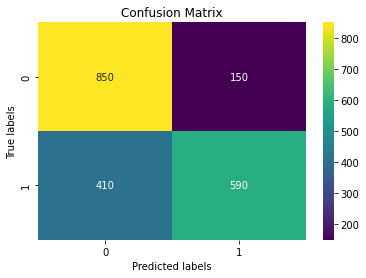

In [23]:
plot_confusion_matrix(task1_test['label'], task1_test['tfidf_prediction'], labels=[0, 1])

Task 2

In [24]:
task_2_test_X = pd.DataFrame(
    task_2_tfidf_vectorizer.transform(task2_test['text']).toarray(),
    columns=task_2_tfidf_vectorizer.get_feature_names()
)

task2_test['tfidf_prediction'] = task_2_tfidf_classifier.predict(task_2_test_X)

print_metrics(task2_test['label'], task2_test['tfidf_prediction'])

Accuracy: 0.6948704389212057
F1: 0.6691934267463981
Macro F1: 0.47341742236342643
Micro F1: 0.6948704389212057
MCC: 0.4478392463288864


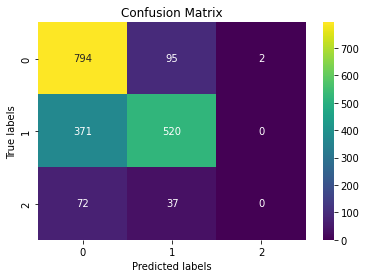

In [25]:
plot_confusion_matrix(task2_test['label'], task2_test['tfidf_prediction'], labels=[0, 1, 2])

Fasttext text classifier

In [26]:
task2_test["text"] = task2_test["text"].astype("string")
task1_test["text"] = task1_test["text"].astype("string")
task1_test["fasttext_prediction"] = -1
task2_test["fasttext_prediction"] = -1

In [27]:
for index, row in task1_test.iterrows():
    task1_test.at[index, 'fasttext_prediction'] = int(task_1_fast_text_classifier.predict(row["text"])[0][0][-1])

In [28]:
for index, row in task2_test.iterrows():
    task2_test.at[index, 'fasttext_prediction'] = int(task_2_fast_text_classifier.predict(row["text"])[0][0][-1])

Task 1

In [29]:
print_metrics(task1_test['label'], task1_test['fasttext_prediction'])

Accuracy: 0.6935
F1: 0.6738423999027381
Macro F1: 0.6738423999027381
Micro F1: 0.6935
MCC: 0.44423549072964275


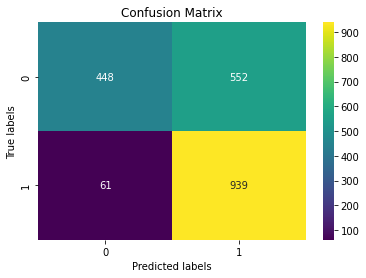

In [30]:
plot_confusion_matrix(task1_test['label'], task1_test['fasttext_prediction'], labels=[0, 1])

Task 2

In [31]:
print_metrics(task2_test['label'], task2_test['fasttext_prediction'])

Accuracy: 0.5478582760444209
F1: 0.4797751154534483
Macro F1: 0.3394144194996149
Micro F1: 0.5478582760444209
MCC: 0.20688923092120048


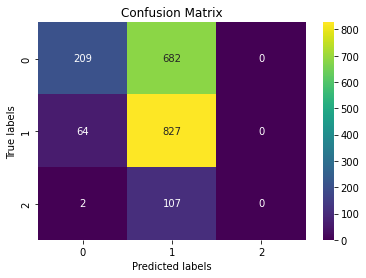

In [32]:
plot_confusion_matrix(task2_test['label'], task2_test['fasttext_prediction'], labels=[0, 1, 2])

Transformer classifier

Task 1

In [ ]:
task_1_predictor = ktrain.get_predictor(
    task_1_transformer_learner.model,
    preproc=task_1_transformer
)

task1_test['transformer_prediction'] =  [
  task_1_predictor.predict(text)
  for text
  in task1_test['text']
]

print_metrics(task1_test['label'], task1_test['transformer_prediction'])

In [ ]:
plot_confusion_matrix(task1_test['label'], task1_test['transformer_prediction'], labels=[0, 1])

Task 2

In [ ]:
task_2_predictor = ktrain.get_predictor(
    task_2_transformer_learner.model,
    preproc=task_2_transformer
)

task2_test['transformer_prediction'] =  [
  task_2_predictor.predict(text)
  for text
  in task2_test['text']
]

print_metrics(task2_test['label'], task2_test['transformer_prediction'])

In [ ]:
plot_confusion_matrix(task2_test['label'], task2_test['transformer_prediction'], labels=[0, 1, 2])

5. Answer the following questions:
    a) Which of the classifiers works the best for the task 1 and the task 2.
    
    Unexpectedly the best classifiers for both datasets is Bayesian classifier with TF * IDF weighting. The other two overfit to one of the class, eventhough at second attemt I used upsampling to balance them.
    
    b) Did you achieve results comparable with the results of PolEval Task?
    
    For task 1 bayes performed worse than any of the result, but in Task 2 we outperform all the result - 99% accuracy. 
    
    c) Describe strengths and weaknesses of each of the compared algorithms.
    
    Bayesian model was the simplest one and didn't took any context of word occurrences, only probabilities. The transformer based model require significant time for training and classification, whereas the bayesian and fasttext classifiers were much faster. 
    
    d) Do you think comparison of raw performance values on a single task is enough to assess the value of a given algorithm/model?
    
    I thinks it's not enough, even for bayes we can observe that in Task 1 we have much worse result comparing to performance in Task 2.

    
    e) Did LIME show that the models use valuable features/words when performing their decision?
    
    LIME shows what incluence in prediciton has given world, but looking into data it's hard to tell if those data are valuable, I don't see many words that may indicate cyberbooling.